## Curve Inversions

Volatility levels have repriced lower on the back of positive vaccine efficacy news and a known US election outcome. Although tail risks are not negligible heading into 2021, we see flat or inverted term structures in several G10 crosses.

In this note, we look at G10 calendar spread ideas to take advantage of term structure dislocations and find that EURUSD stands out as one of the most attractive curve inversions to fade using volatility swaps.

The content of the notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Flattest calendar spreads](#2---Flattest-calendar-spreads)
* [3 - EURUSD](#3---EURUSD)
* [4 - Structure a Vol Steepener](#4---Structure-a-Vol-Steepener)

### 1 -  Let's get started with gs_quant

Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one here. run_analytics scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.229.

In [56]:
from gs_quant.session import GsSession
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics', 'read_financial_data')) 

### 2 - Flattest calendar spreads

Let's start by looking across G10 to compare how steep or flat the volatility spreads of various tenors screen. First, let's grab the data from the [marquee data catalog](). Note, there's also a [premium version available]() with additional currencies and tenors.

In [7]:
from gs_quant.datetime import business_day_offset
from gs_quant.data import Dataset
from dateutil.relativedelta import relativedelta
from datetime import date
import numpy as np
import pandas as pd

g10 = ['USDJPY', 'EURUSD', 'AUDUSD', 'GBPUSD', 'USDCAD', 'USDNOK', 'NZDUSD', 'USDSEK', 'USDCHF']
tenors = ['3m', '6m', '1y']
calendars = ['6m-3m', '1y-6m'] 
end = business_day_offset(date.today(), -1, roll='forward')
start = business_day_offset(end - relativedelta(years=2), -1, roll='forward')

vol_data = Dataset('FXIVOL_STANDARD').get_data(start, end, bbid=g10, tenor=tenors, strikeReference='delta', location='NYC')
vols = pd.pivot_table(vol_data, values='impliedVolatility', index=['date'], columns=['bbid', 'tenor'], aggfunc=np.sum) * 100

With the data in hand, let's look at the spread and the spread ratio. A ratio of less than 1 means the vol curve is inverted because the implied vol for the shorter tenor is higher than the longer tenor. A ratio that's close to 1 is considered flat. We also look at how the spread compares relative to a 2 year history to see how significant the dislocation is in the context of recent history.

In [9]:
from gs_quant.timeseries import last_value, percentiles
pd.set_option('display.precision', 2)

spreads = pd.DataFrame(columns=['Cross', 'Tenors', 'Vol Far', 'Vol Near', 'Spread', 'Ratio', '%-ile'])
for cross in g10:
    for x in calendars:
        far, near = vols[cross, x[:2]], vols[cross, x[3:]]
        vols[cross, x] = far - near
        vols[cross, f'{x}_ratio'] = far / near
        spreads = spreads.append({'Cross': cross, 'Tenors': x, 'Vol Far': last_value(far), 'Vol Near': last_value(near), 
                                  'Spread': last_value(vols[cross, x]), 'Ratio': last_value(vols[cross, f'{x}_ratio']),
                                  '%-ile': last_value(percentiles(vols[cross, f'{x}_ratio']))}, ignore_index=True)
vols = vols.sort_index(level=0, axis=1)
spreads.sort_values(by=['Ratio'], ascending=True).head(15).style.set_caption('15 Flattest Calendars').background_gradient(subset=['Ratio', '%-ile'])

,Cross,Tenors,Vol Far,Vol Near,Spread,Ratio,%-ile
6,GBPUSD,6m-3m,8.95,9.68,-0.73,0.92,20.02
7,GBPUSD,1y-6m,8.40,8.95,-0.55,0.94,19.22
11,USDNOK,1y-6m,11.38,11.80,-0.42,0.96,18.41
10,USDNOK,6m-3m,11.80,12.10,-0.30,0.98,19.22
15,USDSEK,1y-6m,9.26,9.37,-0.12,0.99,10.16
14,USDSEK,6m-3m,9.37,9.48,-0.11,0.99,16.00
3,EURUSD,1y-6m,6.61,6.68,-0.07,0.99,20.42
2,EURUSD,6m-3m,6.68,6.75,-0.07,0.99,21.03
17,USDCHF,1y-6m,6.58,6.64,-0.06,0.99,12.98
16,USDCHF,6m-3m,6.64,6.69,-0.05,0.99,18.81


EURUSD calendar looks relatively attractive as the market is pricing elevated uncertainty in the short term as Covid cases remains elevated in the US / EU. On the other hand, longer maturity vol is seeing large supply by European corporate players which keeps it suppressed. Let's take a closer look. 

### 3 - EURUSD

To start, let's visualize 1y-6m EURUSD vol spread vs 6m implied vol. Any value below the green line indicates an inverted curve - including the current point shown in red. Note you can use the function below to examine any cross or spread from the table above.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_ratio(cross='EURUSD', vol='6m', spread='1y-6m'):
    k = sns.scatterplot(data=vols, x=vols[cross, vol], y=vols[cross, f'{spread}'])
    k.scatter(last_value(vols[cross, vol]), last_value(vols[cross, f'{spread}']), color='red')
    k.axhline(y=0, color='green')
    plt.title(f'{cross} {spread}')
    plt.xlabel(f'{cross} {vol} Implied Volatility')
    plt.ylabel(f'{spread} Implied Vol Spread')
    plt.legend(['Flat', cross, 'Current'])
    plt.show()

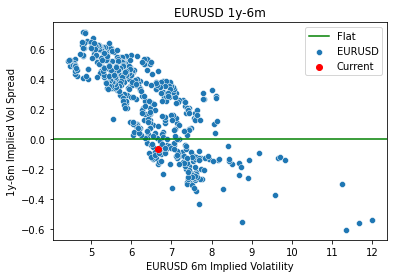

In [14]:
plot_ratio('EURUSD', '6m', '1y-6m')

As we can see, 6m vol is relatively low which offers attractive opportunity to position for vega neutral vol steepeners. Let's put this together next.

### 4 - Structure a Vol Steepener

Let's put together a structure to take advantage of the 1y-6m inverted spread as well as the relatively low 6m vol. To do that, we'll look at a long a 6m6m EURUSD forward starting vol swap and short a 6m EURUSD spot starting vol swap with same vega notional.

In [15]:
from gs_quant.instrument import FXVolatilitySwap
from gs_quant.markets.portfolio import Portfolio

vol_swap = FXVolatilitySwap(pair='EURUSD', buy_sell='Sell', last_fixing_date='6m', strike_vol='atm', notional_amount=250000, name='sell6m')
fwd_vol_swap = FXVolatilitySwap(pair='EURUSD', buy_sell='Buy', first_fixing_date='6m', last_fixing_date='1y', strike_vol='atm', notional_amount=250000, name='buy6m6m')
vol_steepener = Portfolio((vol_swap, fwd_vol_swap)).resolve(in_place=False)

vol_trade = vol_steepener.to_frame()
vol_trade.index = vol_trade.index.droplevel(0)
vol_trade

,asset_class,type,annualization_factor,buy_sell,calculate_mean_return,first_fixing_date,fixing_frequency,fixing_source,last_fixing_date,notional_amount,notional_currency,pair,settlement_date,strike_vol
instrument,,,,,,,,,,,,,,
sell6m (FXVolatilitySwap),AssetClass.FX,AssetType.VolatilitySwap,252.0,BuySell.Sell,0.0,2020-12-17,Daily/Business Days,WM Company LDN 4pm Mid,2021-06-17,-250000.0,Currency.EUR,EUR USD,2021-01-21,0.07
buy6m6m (FXVolatilitySwap),AssetClass.FX,AssetType.VolatilitySwap,252.0,BuySell.Buy,0.0,2021-06-17,Daily/Business Days,WM Company LDN 4pm Mid,2021-12-17,250000.0,Currency.EUR,EUR USD,2021-01-21,0.07


In [16]:
print(f'sell vol strike: {vol_trade.strike_vol.iloc[0] * 100:.2f}')
print(f'buy vol strike: {vol_trade.strike_vol.iloc[1] * 100:.2f}')

sell vol strike: 6.96
buy vol strike: 6.57


Note you can use gs-quant to analyze the risks of this trade using the risk package (`from gs_quant.risk import FXVega, FXGamma, FXDelta`), analyze how it would have performed historically using the `HistoricalPricingContext` and run scenario analysis (check out [the scenario tutorial](https://developer.gs.com/docs/gsquant/tutorials/Pricing-and-Risk/scenarios/) for details).

Please reach out with any feedback and thoughts!